# Basic setting

In [58]:
 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
 
# Device
torch.cuda.set_device(0) # set GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [59]:
num_epochs = 50
num_classes = 10
batch_size = 32
learning_rate = 0.001

# Load CIFAR-10 datasets and use Data Augmentation

In [60]:
# cifar10 classification
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
 
# Data Augumentation
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    ])

val_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    ])
 
# CIFAR-10 dataset
training_dataset = torchvision.datasets.CIFAR10(root='./data/', train=True, transform=train_transform, download=True)
validation_dataset = torchvision.datasets.CIFAR10(root='./data/', train=False, transform=val_transform)
 
# Data loader
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


# View an image and its corresponding label

cat


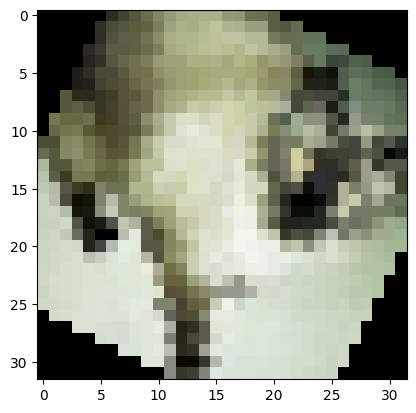

In [63]:
data_iter = iter(training_loader)
images, labels = next(data_iter)
 
idx = 31
image = images[idx].numpy()             # image: (3, 32, 32)
image = np.transpose(image, (1, 2, 0))  # image: (32, 32, 3)
plt.imshow(image)
plt.savefig("expamle.png")
print(classes[labels[idx].numpy()]

# Design the net and train、eval and save the model

In [64]:
model = torchvision.models.vgg19_bn(num_classes=num_classes)
model.to(device)
summary(model, (3, 32, 32), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-3                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-4                       [-1, 64, 32, 32]          36,928
|    └─BatchNorm2d: 2-5                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-6                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-7                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-8                       [-1, 128, 16, 16]         73,856
|    └─BatchNorm2d: 2-9                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-10                        [-1, 128, 16, 16]         --
|    └─Conv2d: 2-11                      [-1, 128, 16, 16]         147,584
|    └─BatchNorm2d: 2-12                 [-1, 128, 16, 16]        

In [65]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=15, gamma=0.5)

# TensorBoard SummaryWriter
writer = SummaryWriter()

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(training_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    scheduler.step()

    average_loss = total_loss / len(training_loader)
    accuracy = 100 * correct / total

    # Record train loss and accuracy to TensorBoard
    writer.add_scalar('Train/Loss', average_loss, epoch)
    writer.add_scalar('Train/Accuracy', accuracy, epoch)
    train_losses.append(average_loss)
    train_accuracies.append(accuracy)

    # Validation
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for i, (images, labels) in enumerate(validation_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_val_loss = val_loss / len(validation_loader)
    val_accuracy = 100 * correct / total

    # Record validation loss and accuracy to TensorBoard
    writer.add_scalar('Validation/Loss', average_val_loss, epoch)
    writer.add_scalar('Validation/Accuracy', val_accuracy, epoch)
    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], train loss: {average_loss:.4f}, train acc: {accuracy:.2f}%, '
          f'val loss: {average_val_loss:.4f}, val acc: {val_accuracy:.2f}%')

# Close TensorBoard SummaryWriter
writer.close()

Epoch [1/50], train loss: 2.5541, train acc: 10.40%, val loss: 2.3028, val acc: 10.00%
Epoch [2/50], train loss: 2.4492, train acc: 10.23%, val loss: 2.3019, val acc: 10.18%
Epoch [3/50], train loss: 2.3118, train acc: 10.94%, val loss: 2.2920, val acc: 10.85%
Epoch [4/50], train loss: 2.2971, train acc: 12.57%, val loss: 2.2823, val acc: 13.54%
Epoch [5/50], train loss: 2.0367, train acc: 18.60%, val loss: 1.9900, val acc: 19.36%
Epoch [6/50], train loss: 1.9491, train acc: 20.63%, val loss: 1.8703, val acc: 23.03%
Epoch [7/50], train loss: 1.8710, train acc: 24.82%, val loss: 2.3358, val acc: 20.84%
Epoch [8/50], train loss: 1.7445, train acc: 30.37%, val loss: 1.6269, val acc: 32.72%
Epoch [9/50], train loss: 1.6179, train acc: 34.97%, val loss: 1.5326, val acc: 38.04%
Epoch [10/50], train loss: 1.5574, train acc: 37.94%, val loss: 1.4744, val acc: 39.73%
Epoch [11/50], train loss: 1.4959, train acc: 42.11%, val loss: 1.3687, val acc: 47.15%
Epoch [12/50], train loss: 1.4280, train 

In [66]:
# Save the model
torch.save(model.state_dict(), 'cifar10_vgg19_v2.pth')

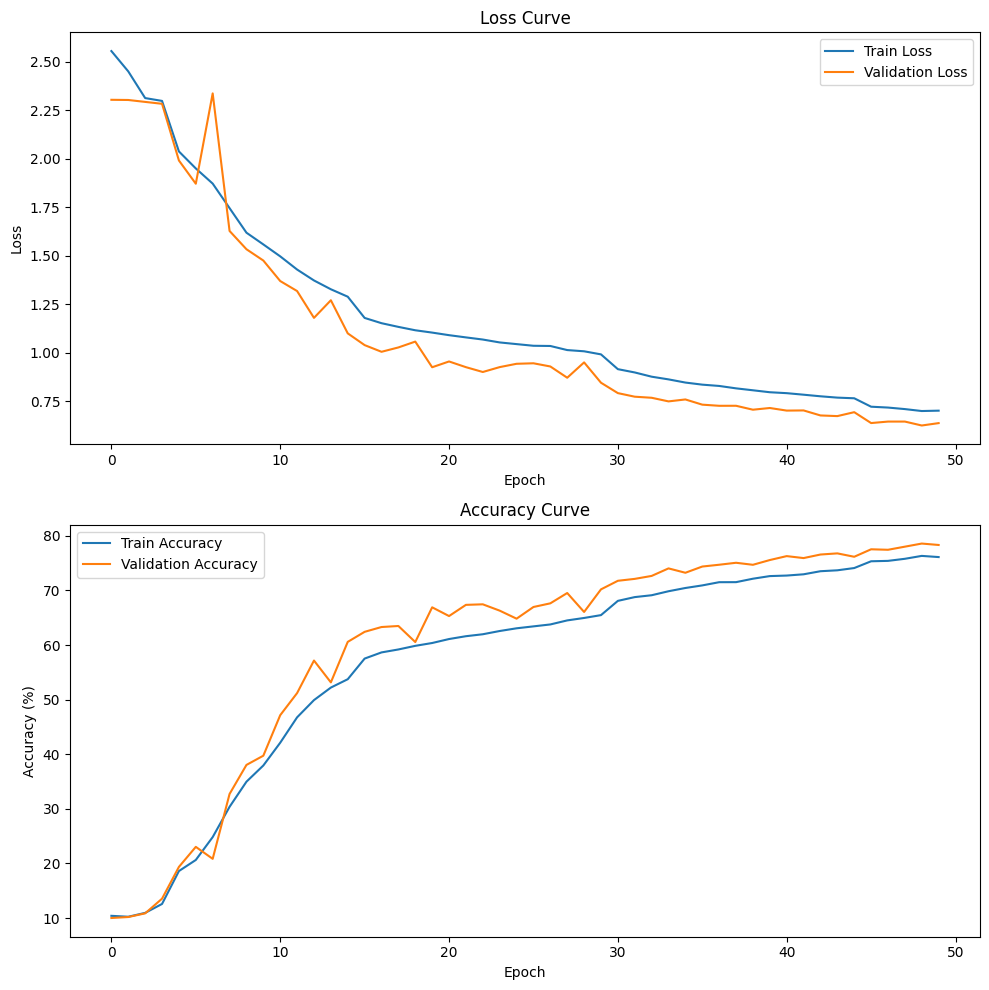

In [67]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# First: Loss Curve
axes[0].plot(range(num_epochs), train_losses, label='Train Loss')
axes[0].plot(range(num_epochs), val_losses, label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss Curve')

# Second: Accuracy Curve
axes[1].plot(range(num_epochs), train_accuracies, label='Train Accuracy')
axes[1].plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].set_title('Accuracy Curve')

plt.tight_layout()
plt.savefig('loss_accuracy_curves.png')
plt.show()

In [36]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the test images: 10.0 %


# Testing

## with Any Image

In [32]:
# Load Weight
test_model = torchvision.models.vgg19_bn(num_classes=10)
test_model.load_state_dict(torch.load('cifar10_vgg19.pth'))
test_model.eval()

<All keys matched successfully>

Predicted as bird


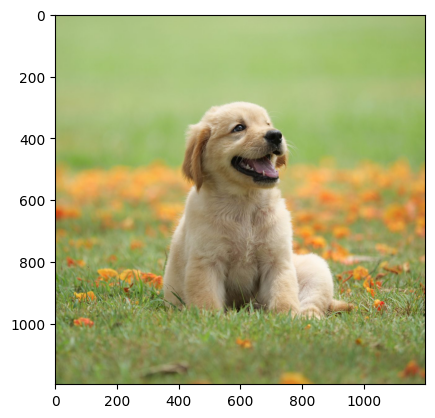

In [51]:
img_path = 'dog.jpg'

transform = transforms.Compose(
    [transforms.ToTensor()]) 

img = Image.open(img_path)  # Load image as PIL.Image
x = transform(img)          # Preprocess image
x = x.unsqueeze(0)
output = test_model(x)      # Forward pass
_, pred = torch.max(output, dim=1)
print('Predicted as', classes[pred[0].item()])

plt.imshow(img)

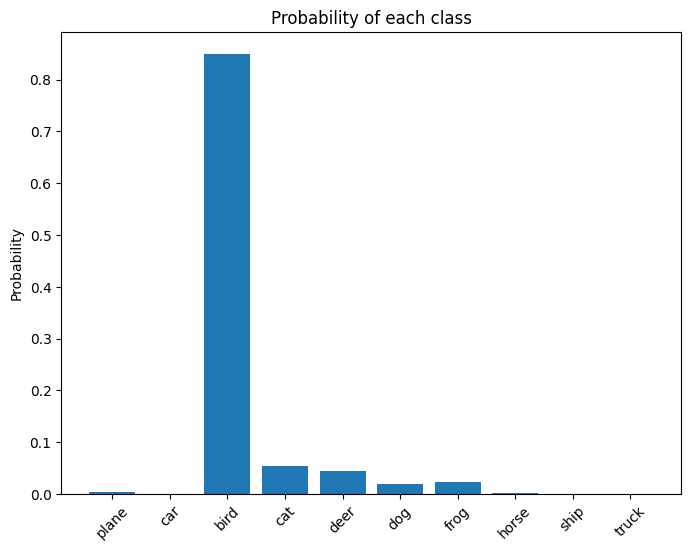

In [50]:
# 將輸出轉換成機率
probabilities = nn.functional.softmax(output[0], dim=0)

plt.figure(figsize=(8, 6))
plt.bar(classes, probabilities.cpu().detach().numpy())
plt.xticks(rotation=45)
plt.ylabel('Probability')
plt.title('Probability of each class')
plt.show()